In [3]:
# ======================
# 1. IMPORTS & CONFIGURATION
# ======================

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.inspection import permutation_importance
import datetime
import warnings

In [26]:
# Set configurations for visualization and data display
sns.set_style("whitegrid")
palette = sns.color_palette("viridis")
plt.rcParams['figure.dpi'] = 120
pd.set_option('display.max_columns', 40)
warnings.filterwarnings('ignore')

# ======================
# 2. DATA PROCESSING
# ======================

# Load the dataset
raw_df = pd.read_csv('hotel_booking.csv')
raw_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,01-07-2015,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,01-07-2015,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,02-07-2015,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,02-07-2015,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,03-07-2015,Linda Hines,LHines@verizon.com,713-226-5883,************5498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,06-09-2017,Claudia Johnson,Claudia.J@yahoo.com,403-092-5582,************8647
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,07-09-2017,Wesley Aguilar,WAguilar@xfinity.com,238-763-0612,************4333
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,07-09-2017,Mary Morales,Mary_Morales@hotmail.com,395-518-4100,************1821
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,07-09-2017,Caroline Conley MD,MD_Caroline@comcast.net,531-528-1017,************7860


In [27]:
# Validate required columns
required_columns = ['hotel', 'is_canceled', 'lead_time', 'adults']
missing = [col for col in required_columns if col not in raw_df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Handle missing values
raw_df['children'] = raw_df['children'].fillna(0)  # Assuming no children if value is missing
raw_df['country'] = raw_df['country'].fillna('Others')  # Replace missing countries with 'Others'
raw_df['agent'] = raw_df['agent'].fillna(0)  # Assuming no agent involvement if value is missing
raw_df['company'] = raw_df['company'].fillna(0)  # Assuming no company involvement if value is missing

# Filter out rows where adults is zero or negative
clean_df = raw_df[raw_df['adults'] > 0]
clean_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,01-07-2015,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,01-07-2015,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0.0,0,Transient,75.00,0,0,Check-Out,02-07-2015,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0.0,0,Transient,75.00,0,0,Check-Out,02-07-2015,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,98.00,0,1,Check-Out,03-07-2015,Linda Hines,LHines@verizon.com,713-226-5883,************5498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,0.0,0,Transient,96.14,0,0,Check-Out,06-09-2017,Claudia Johnson,Claudia.J@yahoo.com,403-092-5582,************8647
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,0.0,0,Transient,225.43,0,2,Check-Out,07-09-2017,Wesley Aguilar,WAguilar@xfinity.com,238-763-0612,************4333
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,0.0,0,Transient,157.71,0,4,Check-Out,07-09-2017,Mary Morales,Mary_Morales@hotmail.com,395-518-4100,************1821
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,0.0,0,Transient,104.40,0,0,Check-Out,07-09-2017,Caroline Conley MD,MD_Caroline@comcast.net,531-528-1017,************7860


In [28]:
# Feature Engineering
months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]
clean_df['arrival_date_month'] = pd.Categorical(
    clean_df['arrival_date_month'], 
    categories=months, 
    ordered=True
)
clean_df['total_nights'] = clean_df['stays_in_weekend_nights'] + clean_df['stays_in_week_nights']
clean_df['arrival_year_month'] = clean_df['arrival_date_year'].astype(str) + '-' + \
    clean_df['arrival_date_month'].str[:3]
clean_df['arrival_month_num'] = clean_df['arrival_date_month'].cat.codes + 1
clean_df['lead_time_x_deposit'] = clean_df['lead_time'] * (clean_df['deposit_type'] == 'Non Refund').astype(int)
clean_df['special_requests_flag'] = (clean_df['total_of_special_requests'] > 0).astype(int)
clean_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card,total_nights,arrival_year_month,arrival_month_num,lead_time_x_deposit,special_requests_flag
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,...,3,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,01-07-2015,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322,0,2015-Jul,7,0,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,...,4,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,01-07-2015,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157,0,2015-Jul,7,0,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,...,0,No Deposit,0.0,0.0,0,Transient,75.00,0,0,Check-Out,02-07-2015,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734,1,2015-Jul,7,0,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,...,0,No Deposit,304.0,0.0,0,Transient,75.00,0,0,Check-Out,02-07-2015,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677,1,2015-Jul,7,0,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,...,0,No Deposit,240.0,0.0,0,Transient,98.00,0,1,Check-Out,03-07-2015,Linda Hines,LHines@verizon.com,713-226-5883,************5498,2,2015-Jul,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,...,0,No Deposit,394.0,0.0,0,Transient,96.14,0,0,Check-Out,06-09-2017,Claudia Johnson,Claudia.J@yahoo.com,403-092-5582,************8647,7,2017-Aug,8,0,0
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,...,0,No Deposit,9.0,0.0,0,Transient,225.43,0,2,Check-Out,07-09-2017,Wesley Aguilar,WAguilar@xfinity.com,238-763-0612,************4333,7,2017-Aug,8,0,1
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,...,0,No Deposit,9.0,0.0,0,Transient,157.71,0,4,Check-Out,07-09-2017,Mary Morales,Mary_Morales@hotmail.com,395-518-4100,************1821,7,2017-Aug,8,0,1
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,...,0,No Deposit,89.0,0.0,0,Transient,104.40,0,0,Check-Out,07-09-2017,Caroline Conley MD,MD_Caroline@comcast.net,531-528-1017,************7860,7,2017-Aug,8,0,0


[Text(0, 0, 'Not Canceled'), Text(1, 0, 'Canceled')]

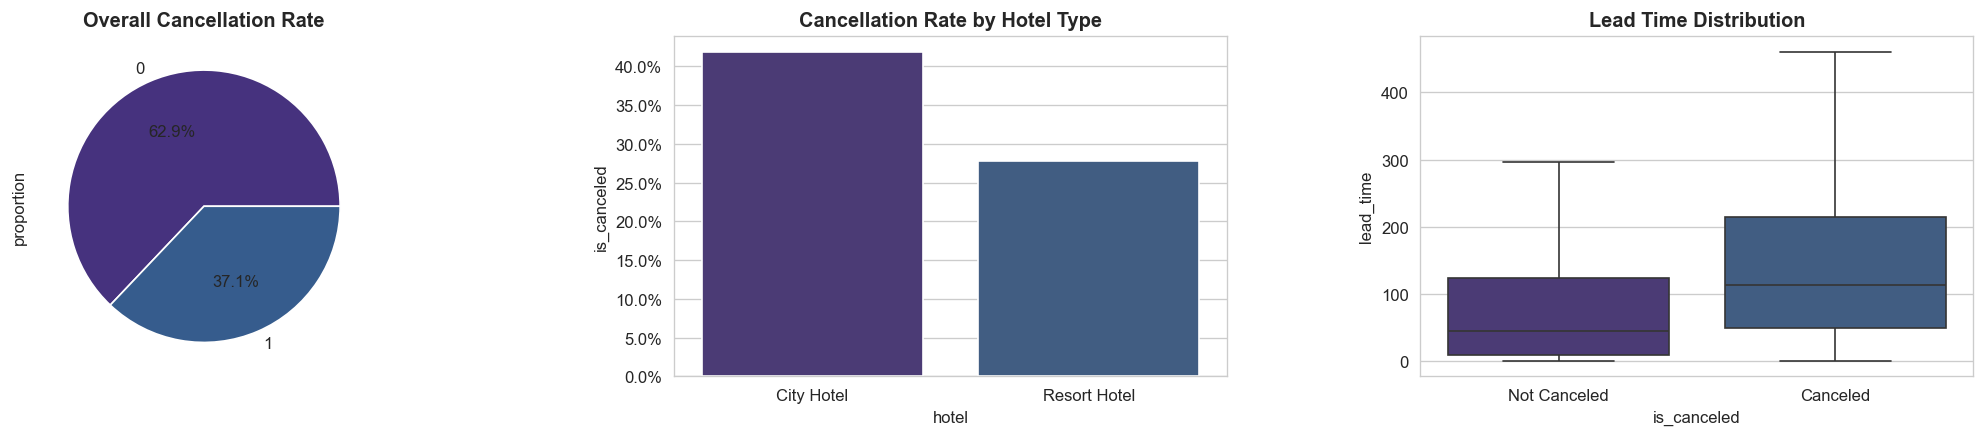

In [29]:
# ======================
# 3. VISUAL ANALYTICS 
# ======================

# Create main figure with original dimensions
fig = plt.figure(figsize=(22, 35))
grid = plt.GridSpec(6, 3, hspace=0.7, wspace=0.35)

# Plot 1: Overall Cancellation Rate
ax1 = fig.add_subplot(grid[0, 0])
clean_df['is_canceled'].value_counts(normalize=True).plot.pie(
    ax=ax1, autopct='%1.1f%%', colors=palette,
    wedgeprops={'linewidth':1, 'edgecolor':'white'}
)
ax1.set_title('Overall Cancellation Rate', fontweight='bold')

# Plot 2: Cancellation Rate by Hotel Type
ax2 = fig.add_subplot(grid[0, 1])
sns.barplot(x='hotel', y='is_canceled', data=clean_df, errorbar=None, 
    palette=palette, order=['City Hotel', 'Resort Hotel'], ax=ax2)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.set_title('Cancellation Rate by Hotel Type', fontweight='bold')

# Plot 3: Lead Time Distribution
ax3 = fig.add_subplot(grid[0, 2])
sns.boxplot(x='is_canceled', y='lead_time', data=clean_df, palette=palette, 
    showfliers=False, ax=ax3)
ax3.set_title('Lead Time Distribution', fontweight='bold')
ax3.set_xticklabels(['Not Canceled', 'Canceled'])

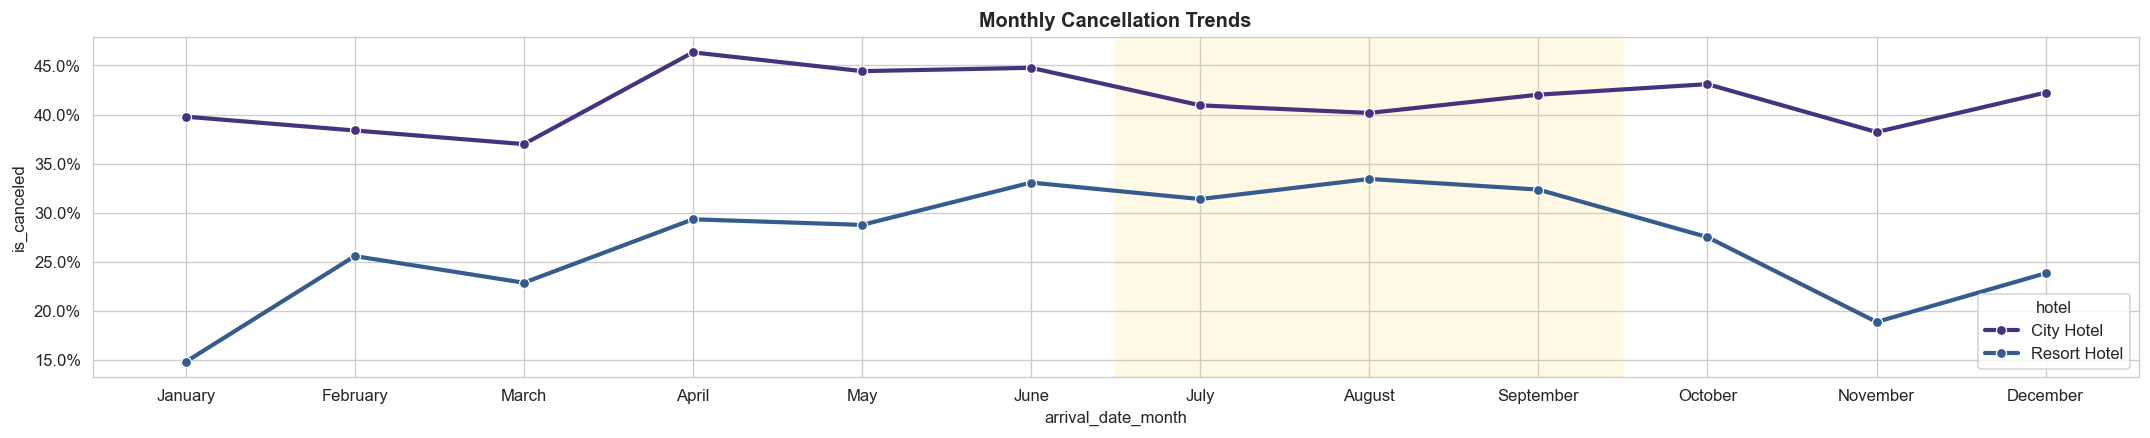

In [30]:
# Create main figure with original dimensions
fig = plt.figure(figsize=(22, 35))
grid = plt.GridSpec(6, 3, hspace=0.7, wspace=0.35)

# Plot 4: Monthly Cancellation Trends
ax4 = fig.add_subplot(grid[1, :])
monthly_data = clean_df.groupby(['arrival_date_month', 'hotel'])['is_canceled'].mean().reset_index()
sns.lineplot(x='arrival_date_month', y='is_canceled', hue='hotel',
    data=monthly_data, marker='o', palette=palette, linewidth=2.5,
    sort=False, ax=ax4)
ax4.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax4.set_title('Monthly Cancellation Trends', fontweight='bold')
ax4.axvspan(5.5, 8.5, color='gold', alpha=0.1, label='Peak Season')

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

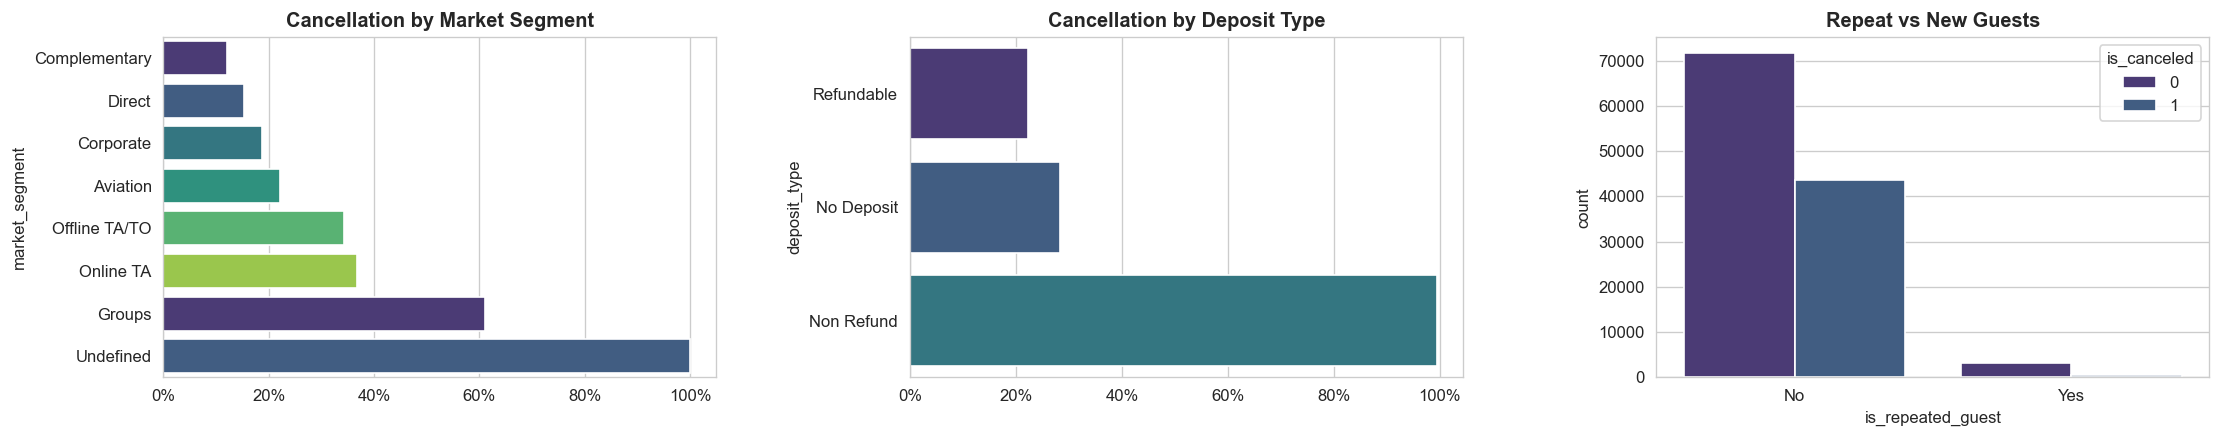

In [31]:
# Create main figure with original dimensions
fig = plt.figure(figsize=(22, 35))
grid = plt.GridSpec(6, 3, hspace=0.7, wspace=0.35)

# Plot 5: Cancellation by Market Segment
ax5 = fig.add_subplot(grid[2, 0])
segment_cancel = clean_df.groupby('market_segment')['is_canceled'].mean().sort_values()
sns.barplot(y=segment_cancel.index, x=segment_cancel.values, palette=palette, ax=ax5)
ax5.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax5.set_title('Cancellation by Market Segment', fontweight='bold')

# Plot 6: Cancellation by Deposit Type
ax6 = fig.add_subplot(grid[2, 1])
deposit_cancel = clean_df.groupby('deposit_type')['is_canceled'].mean().sort_values()
sns.barplot(y=deposit_cancel.index, x=deposit_cancel.values, palette=palette, ax=ax6)
ax6.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax6.set_title('Cancellation by Deposit Type', fontweight='bold')

# Plot 7: Repeat vs New Guests
ax7 = fig.add_subplot(grid[2, 2])
sns.countplot(x='is_repeated_guest', hue='is_canceled', data=clean_df, palette=palette, ax=ax7)
ax7.set_title('Repeat vs New Guests', fontweight='bold')
ax7.set_xticklabels(['No', 'Yes'])

Text(0.5, 1.0, 'Feature Correlation Matrix')

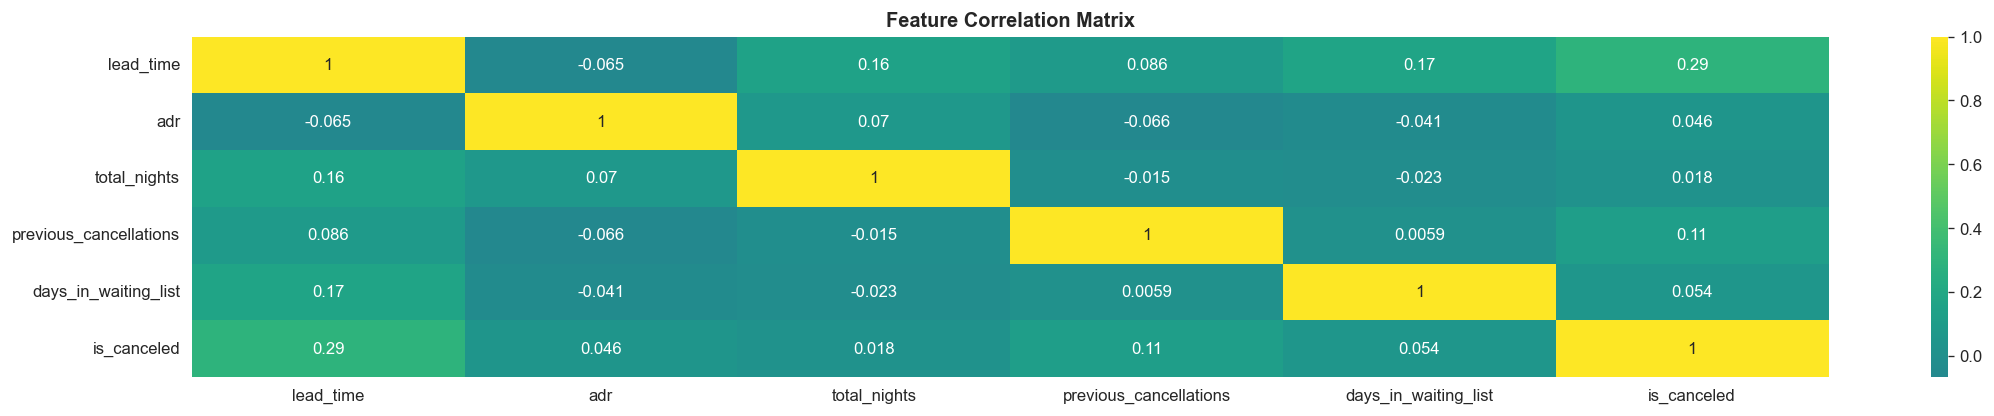

In [32]:
# Create main figure with original dimensions
fig = plt.figure(figsize=(22, 35))
grid = plt.GridSpec(6, 3, hspace=0.7, wspace=0.35)

# Plot 8: Feature Correlation Matrix
ax8 = fig.add_subplot(grid[3, :])
corr_matrix = clean_df[['lead_time', 'adr', 'total_nights', 'previous_cancellations',
    'days_in_waiting_list', 'is_canceled']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='viridis', center=0, ax=ax8)
ax8.set_title('Feature Correlation Matrix', fontweight='bold')

Text(0.5, 1.0, 'Special Requests Impact')

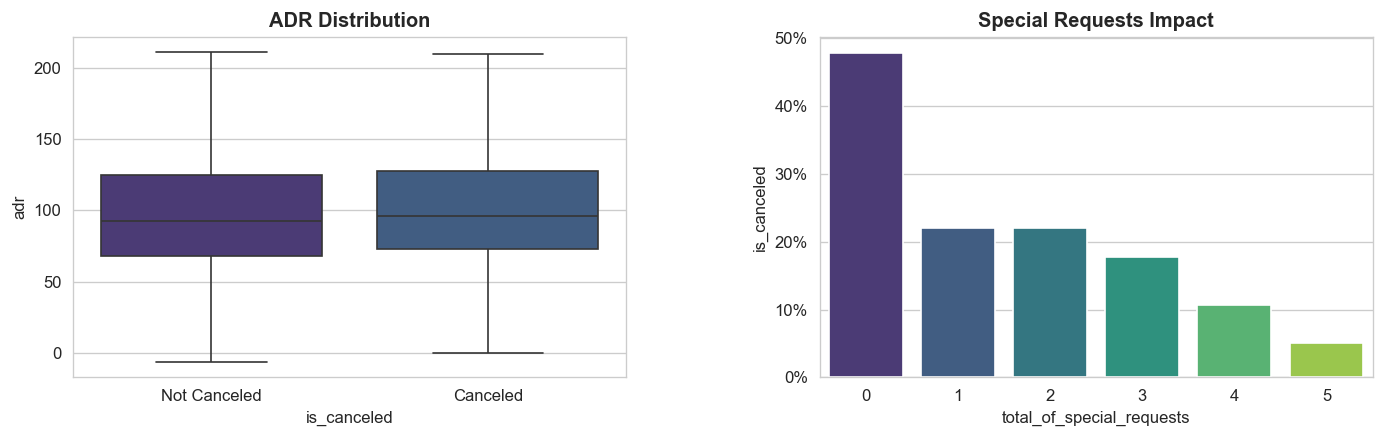

In [33]:
# Create main figure with original dimensions
fig = plt.figure(figsize=(22, 35))
grid = plt.GridSpec(6, 3, hspace=0.7, wspace=0.35)

# Plot 9: ADR Distribution
ax9 = fig.add_subplot(grid[4, 0])
sns.boxplot(x='is_canceled', y='adr', data=clean_df, palette=palette, showfliers=False, ax=ax9)
ax9.set_xticklabels(['Not Canceled', 'Canceled'])
ax9.set_title('ADR Distribution', fontweight='bold')

# Plot 10: Special Requests Impact
ax10 = fig.add_subplot(grid[4, 1])
sns.barplot(x='total_of_special_requests', y='is_canceled', data=clean_df, 
    errorbar=None, palette=palette, ax=ax10)
ax10.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax10.set_title('Special Requests Impact', fontweight='bold')

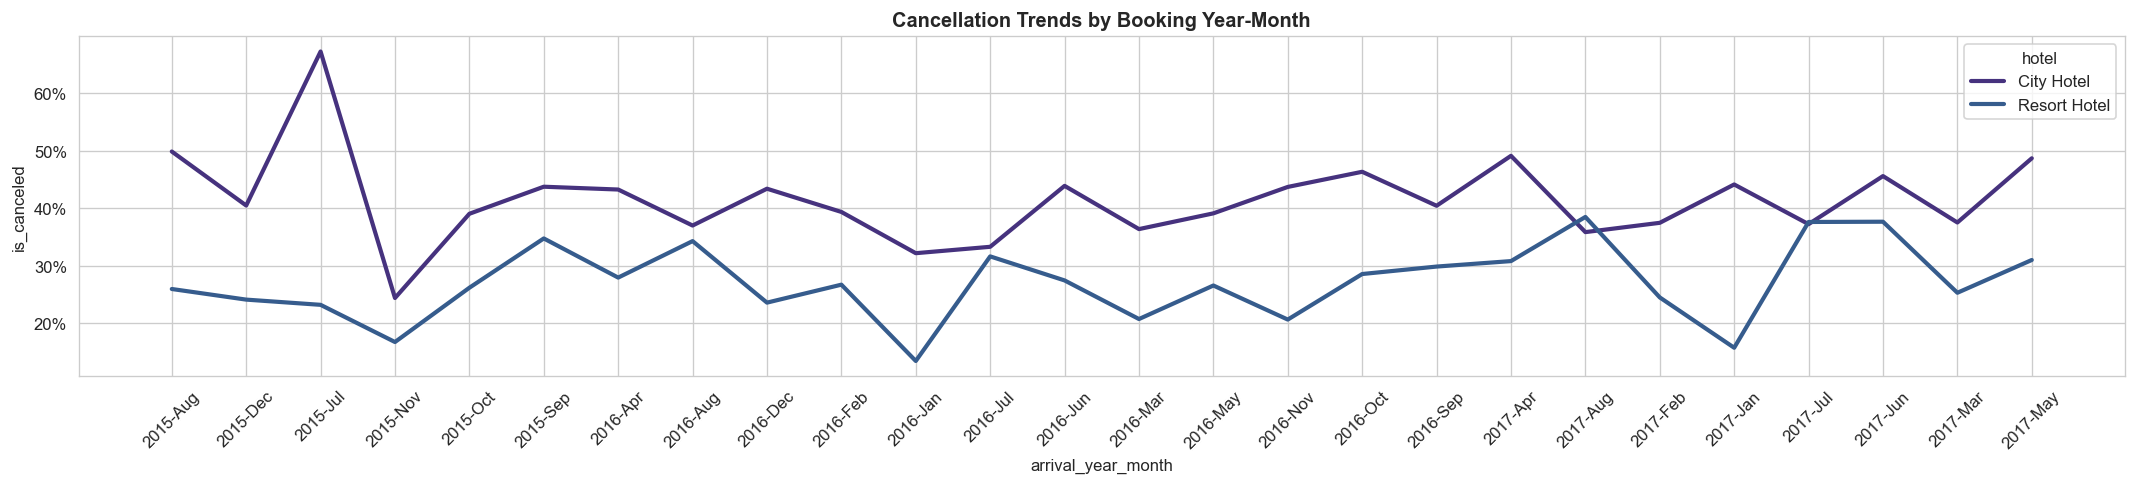

In [34]:
# Create main figure with original dimensions
fig = plt.figure(figsize=(22, 35))
grid = plt.GridSpec(6, 3, hspace=0.7, wspace=0.35)

# Plot 11: Cancellation Trends by Booking Year-Month
ax11 = fig.add_subplot(grid[5, :])
year_month_data = clean_df.groupby(['arrival_year_month', 'hotel'])['is_canceled'].mean().reset_index()
sns.lineplot(x='arrival_year_month', y='is_canceled', hue='hotel',
    data=year_month_data, palette=palette, linewidth=2.5, ax=ax11)
ax11.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax11.set_title('Cancellation Trends by Booking Year-Month', fontweight='bold')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(f'hotel_analysis_{datetime.date.today().isoformat()}.png')
plt.show()

In [35]:
# ======================
# 4. PREDICTIVE MODELING
# ======================

# Define features and preprocessing steps
features = [
    'hotel', 'lead_time', 'arrival_month_num',
    'total_nights', 'market_segment', 'deposit_type',
    'customer_type', 'adr', 'lead_time_x_deposit'
]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(max_categories=8, handle_unknown='ignore'), 
     ['hotel', 'market_segment', 'deposit_type']),
    ('num', StandardScaler(), ['lead_time', 'total_nights', 'adr', 'arrival_month_num'])
])

# Split data into training and testing sets
train_df = clean_df[clean_df['arrival_date_year'].isin([2015, 2016])]
test_df = clean_df[clean_df['arrival_date_year'] == 2017]

# Train Random Forest Model
rf_pipeline = make_pipeline(preprocessor, 
    RandomForestClassifier(class_weight='balanced', n_estimators=300,
                           max_depth=8, random_state=42))
rf_pipeline.fit(train_df[features], train_df['is_canceled'])

# Evaluate the model
y_pred = rf_pipeline.predict(test_df[features])
y_true = test_df['is_canceled']

print("\nRANDOM FOREST PERFORMANCE:")
print(f"ROC AUC: {roc_auc_score(y_true, y_pred):.2f}")
print(classification_report(y_true, y_pred))


RANDOM FOREST PERFORMANCE:
ROC AUC: 0.71
              precision    recall  f1-score   support

           0       0.82      0.65      0.73     24854
           1       0.58      0.77      0.66     15703

    accuracy                           0.70     40557
   macro avg       0.70      0.71      0.69     40557
weighted avg       0.73      0.70      0.70     40557



In [36]:
# ======================
# 5. BUSINESS INSIGHTS
# ======================

# Generate business insights
current_median_wait = clean_df['days_in_waiting_list'].median()
dynamic_pricing_candidates = len(clean_df[
    (clean_df['lead_time'] > 90) & 
    (clean_df['adr'] > clean_df.groupby('hotel')['adr'].transform('median'))
])
loyalty_prospects = clean_df[
    (clean_df['total_of_special_requests'] >= 2) & 
    (clean_df['previous_cancellations'] == 0)
].shape[0]

print("\n=== BUSINESS RECOMMENDATIONS ===")
print(f"1. Current median waitlist days: {current_median_wait:.1f}")
print(f"2. Dynamic pricing candidates: {dynamic_pricing_candidates} bookings")
print(f"3. Loyalty program prospects: {loyalty_prospects} guests")


=== BUSINESS RECOMMENDATIONS ===
1. Current median waitlist days: 0.0
2. Dynamic pricing candidates: 25221 bookings
3. Loyalty program prospects: 15430 guests


In [37]:
# Save outputs
joblib.dump(rf_pipeline, 'cancellation_predictor.pkl')
clean_df.to_csv('enhanced_hotel_bookings.csv', index=False)